# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline


# from IPython.core.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

import numpy as np


from metrics import multiclass_accuracy 


## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [118]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [119]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [120]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [5]:
nn_model = nn.Sequential()
nn_model.add_module("Flattener",Flattener())
nn_model.add_module("Linear1",nn.Linear(3*32*32, 100))
nn_model.add_module("ReLU",nn.ReLU(inplace=True))
nn_model.add_module("Linear2",nn.Linear(100, 10))
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [6]:
# code to print train history accuracy

from torchvision import models

import matplotlib.pyplot as plt
def plot_history(loss_history, train_history, val_history):
    
    # print("model summary:")
    # model = models.vgg16()
    # print(nn_model)
    
    # plt.plot(loss_history/np.mean(loss_history))
    plt.ylabel('Accuracy @ epoch')
    
    train, = plt.plot(train_history)
    train.set_label("train")
    validation, = plt.plot(val_history)
    validation.set_label("validation")

    plt.legend()
    plt.show()


In [7]:
# code to print network structure

# !conda install torchviz
# !conda install python-graphviz
# !conda install pydot
from torchviz import make_dot, make_dot_from_trace
def plot_model(n_model, size_x, size_y):
    model = n_model
    x = torch.randn(size_x ,size_y)
    make_dot(model(x), params=dict(model.named_parameters()))



In [8]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        
        # here!
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # https://stackoverflow.com/questions/52176178/pytorch-model-accuracy-test
    accuracies = []
    
    for i_step, (x,y) in enumerate(loader):
        output = model.forward(x)
        output_prediction = torch.argmax(output, dim=1)
        # print(output_prediction.shape, y.shape)
        accuracy = multiclass_accuracy(output_prediction, y)
        # print (i_step, accuracy)
        accuracies.append(accuracy)
        
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    return np.mean(accuracies)


Average loss: 1.832044, Train accuracy: 0.410368, Val accuracy: 0.554168
Average loss: 1.456360, Train accuracy: 0.589069, Val accuracy: 0.617964
Average loss: 1.377894, Train accuracy: 0.622735, Val accuracy: 0.629279


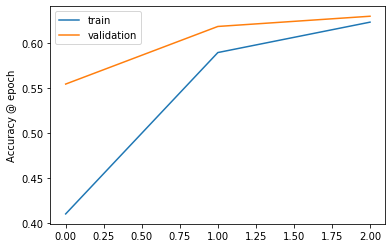

In [9]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)
plot_history(loss_history, train_history, val_history)

## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [10]:
# Since it's so easy to add layers, let's add some!


# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100,10),
    nn.Linear(10,100)
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

Average loss: 2.466906, Train accuracy: 0.211753, Val accuracy: 0.296803
Average loss: 1.960639, Train accuracy: 0.337457, Val accuracy: 0.389740
Average loss: 1.755675, Train accuracy: 0.416067, Val accuracy: 0.427575
Average loss: 1.713806, Train accuracy: 0.431577, Val accuracy: 0.423384
Average loss: 1.699901, Train accuracy: 0.436730, Val accuracy: 0.447464


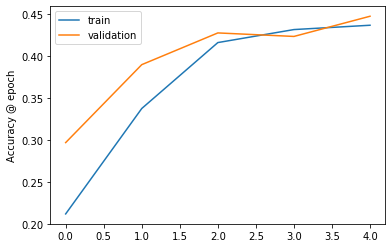

In [11]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)
plot_history(loss_history, train_history, val_history)

Добавьте слой с Batch Normalization

In [12]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100,10),
    nn.Linear(10,100),
    nn.BatchNorm1d(100)
       )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)


Average loss: 4.218558, Train accuracy: 0.194417, Val accuracy: 0.419216
Average loss: 3.477714, Train accuracy: 0.491144, Val accuracy: 0.583525
Average loss: 3.126730, Train accuracy: 0.605313, Val accuracy: 0.660439
Average loss: 2.870080, Train accuracy: 0.676194, Val accuracy: 0.703641
Average loss: 2.690388, Train accuracy: 0.709108, Val accuracy: 0.720266


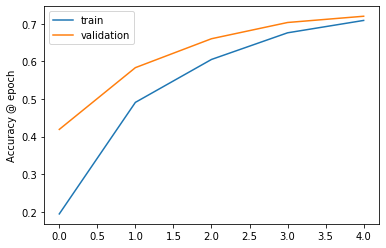

In [13]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)
plot_history(loss_history, train_history, val_history)

Добавьте уменьшение скорости обучения по ходу тренировки.

In [18]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

# https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/

from torch.optim.lr_scheduler import StepLR

def train_model_with_learning_rate_decay(model, train_loader, val_loader, loss, num_epochs, learning_rate = 0.001):    
    loss_history = []
    train_history = []
    val_history = []
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, nesterov=True)
    
    
    # step_size: at how many multiples of epoch you decay
    # step_size = 1, after every 2 epoch, new_lr = lr*gamma 
    # step_size = 2, after every 2 epoch, new_lr = lr*gamma 

    # gamma = decaying factor
    scheduler = StepLR(optimizer, step_size = 2, gamma = 0.5)
    
    
    for epoch in range(num_epochs):        
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        print("Epoch: ", epoch, "lr: ", scheduler.get_last_lr())
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        scheduler.step()            
            
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        
        # here!
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100,10),
    nn.Linear(10,100),
    nn.BatchNorm1d(100),
    nn.Linear(100,10)
       )

Epoch:  0 lr:  [0.001]
Average loss: 1.339861, Train accuracy: 0.570334, Val accuracy: 0.718652
Epoch:  1 lr:  [0.001]
Average loss: 0.885520, Train accuracy: 0.732297, Val accuracy: 0.741310
Epoch:  2 lr:  [0.0005]
Average loss: 0.719255, Train accuracy: 0.787462, Val accuracy: 0.789425
Epoch:  3 lr:  [0.0005]
Average loss: 0.674930, Train accuracy: 0.799219, Val accuracy: 0.799523
Epoch:  4 lr:  [0.00025]
Average loss: 0.608005, Train accuracy: 0.820923, Val accuracy: 0.820067


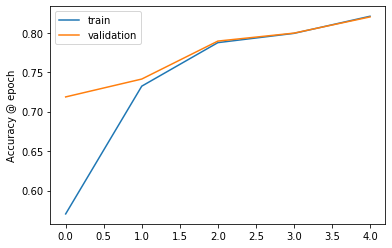

In [19]:
loss_history, train_history, val_history = train_model_with_learning_rate_decay(nn_model, train_loader, val_loader, loss, 5)
plot_history(loss_history, train_history, val_history)

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [20]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    sampler = SubsetSampler(indices)
    
    loader = torch.utils.data.DataLoader(dataset, sampler=sampler)

    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    predictions  =  torch.zeros([len(sampler)], dtype=torch.int32)
    ground_truth = torch.zeros([len(sampler)], dtype=torch.int32)
    
    for i_step, (x,y) in enumerate(loader):
        # print (i_step, x,y)        
        output = model.forward(x)
        predictions[i_step] =  torch.argmax(output, dim=1)
        ground_truth[i_step] = y
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)

print (predictions, gt)

assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
# assert np.any(np.not_equal(gt, predictions))

tensor([1, 0, 0,  ..., 4, 0, 7], dtype=torch.int32) tensor([1, 0, 0,  ..., 4, 0, 7], dtype=torch.int32)


## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

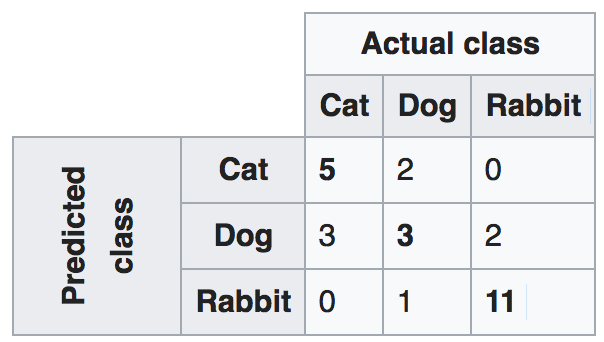

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

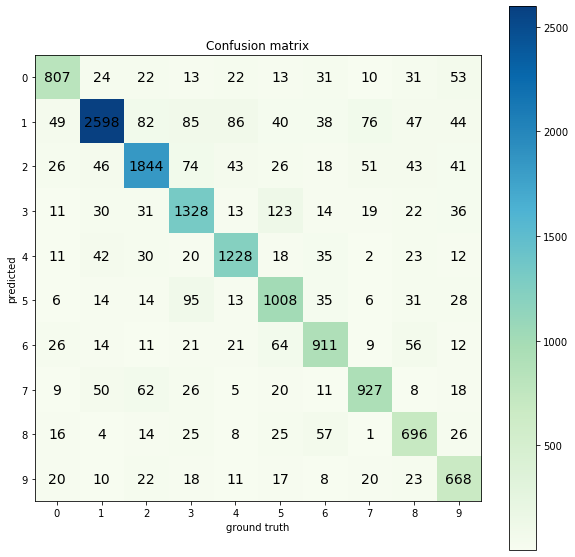

In [21]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    for i in range(len(predictions)):
        prediction = predictions[i]
        truth = gt[i]
        confusion_matrix [prediction, truth] += 1 
    
    # TODO: Implement filling the prediction matrix
    #return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return confusion_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

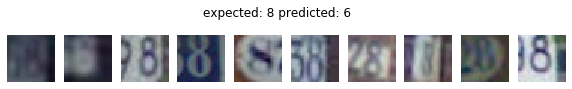

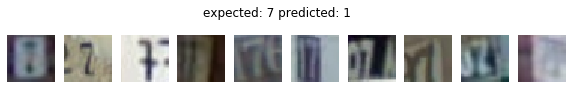

In [22]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    # print(indices)
    
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, ground_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # print(predictions.shape, ground_truth.shape, val_indices.shape)
    wrong_ind = []
    for i in range(len(val_indices)):
        if (predictions[i] == predicted_class) and (ground_truth[i] == gt_class) :
            wrong_ind.append(val_indices[i])
    
    visualize_images(wrong_ind, data, "expected: " +str(gt_class)+ " predicted: "+ str(predicted_class))

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

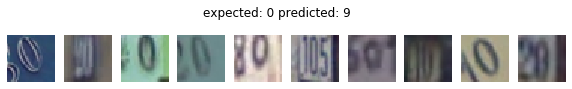

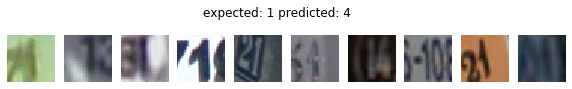

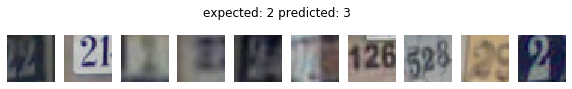

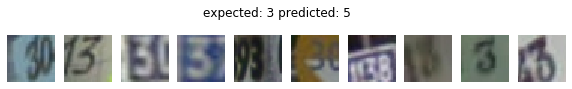

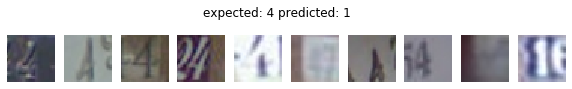

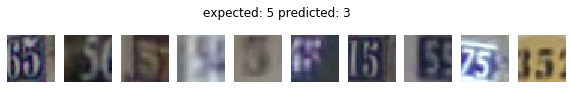

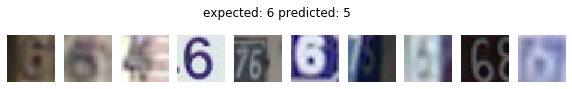

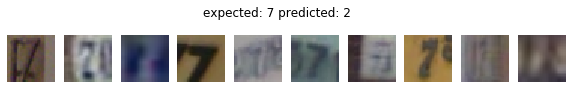

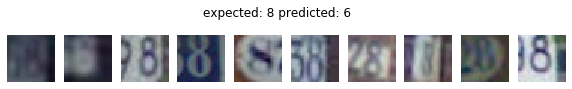

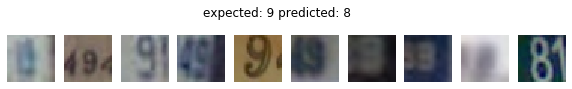

In [23]:
def draw_confusions(predictions, gt):
    confusion_matrix = build_confusion_matrix(predictions, gt)
    np.fill_diagonal(confusion_matrix, 0)
    for i in range(10):
        max_wrong_ind = np.argmax(confusion_matrix[i])
        visualize_predicted_actual(max_wrong_ind, i, predictions, gt, np.array(val_indices), data_train_images)
        
draw_confusions(predictions, gt)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [156]:
# Experiment here!
def train_model_with_learning_rate_decay2(model, train_loader, val_loader, loss, num_epochs, learning_rate = 0.001, step_size = 2, gamma = 0.5):    
    loss_history = []
    train_history = []
    val_history = []
    
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9, nesterov=True)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    
    # step_size: at how many multiples of epoch you decay
    # step_size = 1, after every 2 epoch, new_lr = lr*gamma 
    # step_size = 2, after every 2 epoch, new_lr = lr*gamma 

    # gamma = decaying factor
    scheduler = StepLR(optimizer, step_size = step_size, gamma = gamma)
    
    
    for epoch in range(num_epochs):        
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        print("Epoch: ", epoch, "lr: ", scheduler.get_last_lr())
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        scheduler.step()            
            
        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [157]:
# https://stackoverflow.com/questions/53570732/get-single-random-example-from-pytorch-dataloader
for test_images, test_labels in train_loader:  
    sample_image = test_images[0]    # Reshape them according to your needs.
    sample_label = test_labels[0]
    break
sample_image.shape

def image_2_vec_gradient_for(pic):
    # print("picargmax",torch.max(pic, axis = 0))
    pic_gray = torch.max(pic, axis = 0).values
    # print("pic_gray",pic_gray.shape)
    
    result = torch.zeros(16,16,2)
    
    for i in range(15):
        for j in range(15):
            quad = torch.zeros((2,2))
            quad[0,0] = pic_gray[2*i,2*j]
            quad[0,1] = pic_gray[2*i+1, 2*j]
            quad[1,0] = pic_gray[2*i, 2*j+1]
            quad[1,1] = pic_gray[2*i+1, 2*j+1]
            #print(quad)
            result[i,j] = (torch.argmax(quad,axis = 0) - torch.argmin(quad, axis = 0))
            # print("argmax", np.argmax(quad, axis = 0), "argmin", np.argmin(quad, axis = 0))
            #print(vx)

    return result

def image_2_vec_gradient_index(pic):
    pic_gray = torch.sum(pic, axis = 0)#.values
    # print("pic_gray",pic_gray.shape)

    quads = torch.zeros(16,16,2,2)
    result = torch.zeros(16,16,2)
    
    # https://stackoverflow.com/questions/10198747/how-can-i-simultaneously-select-all-odd-rows-and-all-even-columns-of-an-array
    result[:,:,0] = pic_gray[::2,::2]
    
    #print(result)
    quads[:,:,0,0] = pic_gray[::2,::2]
    quads[:,:,0,1] = pic_gray[1::2, ::2]
    quads[:,:,1,0] = pic_gray[::2, 1::2]
    quads[:,:,1,1] = pic_gray[1::2, 1::2]
    
    # print(quads)
    #result[:,:] = torch.argmax(quads[:,:], dim =1) - torch.argmin(quads[:,:], dim = 1)
    result = torch.argmax(quads[:,:], dim = 2)- torch.argmin(quads[:,:], dim = 2)
    
    return result

for1 = image_2_vec_gradient_for(sample_image)
ind1 =  image_2_vec_gradient_index(sample_image)

# https://stackoverflow.com/questions/32996281/how-to-check-if-two-torch-tensors-or-matrices-are-equal
assert torch.any(torch.eq(for1, ind1))

In [169]:
class Flattener1(nn.Module):
    def forward(self, x):
        #print(x.shape)
        batch_size, rgb, row, col = x.shape
        
        res = torch.zeros((batch_size,16,16,2))
        
        for batch in range(batch_size):
            pic = x[batch]
            #print("pic",pic) 
            res[batch] = image_2_vec_gradient_index(pic)
        #res[:] = image_2_vec_gradient_index(x[:])
        
        #result = x.view(batch_size, -1)
        # print("res",res)
        # return result
        return res.view(batch_size,-1)
    
nn_model = nn.Sequential(
    Flattener1(),
    nn.Linear(16*16*2, 800),
    nn.ReLU(inplace=True),
    nn.Linear(800,150),
    nn.Dropout(p = 0.5, inplace = True),
    nn.BatchNorm1d(150),
    #nn.Linear(200,100),
    #nn.BatchNorm1d(100),
    nn.Linear(150,10)
)

Epoch:  0 lr:  [0.12]
Average loss: 1.987784, Train accuracy: 0.338566, Val accuracy: 0.524043
Epoch:  1 lr:  [0.08399999999999999]
Average loss: 1.366521, Train accuracy: 0.548289, Val accuracy: 0.617436
Epoch:  2 lr:  [0.05879999999999999]
Average loss: 1.103202, Train accuracy: 0.639917, Val accuracy: 0.668342
Epoch:  3 lr:  [0.04115999999999999]
Average loss: 0.937314, Train accuracy: 0.695645, Val accuracy: 0.704584
Epoch:  4 lr:  [0.02881199999999999]
Average loss: 0.815749, Train accuracy: 0.733406, Val accuracy: 0.717350
Epoch:  5 lr:  [0.020168399999999993]
Average loss: 0.701231, Train accuracy: 0.773419, Val accuracy: 0.715451
Epoch:  6 lr:  [0.014117879999999994]
Average loss: 0.606740, Train accuracy: 0.802222, Val accuracy: 0.725453
Epoch:  7 lr:  [0.009882515999999996]
Average loss: 0.524475, Train accuracy: 0.831195, Val accuracy: 0.721330
Epoch:  8 lr:  [0.006917761199999996]
Average loss: 0.457292, Train accuracy: 0.850630, Val accuracy: 0.729847


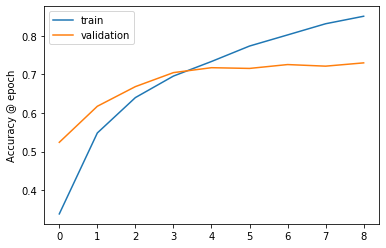

In [170]:
loss_history, train_history, val_history = train_model_with_learning_rate_decay2(
    model = nn_model,
    train_loader = train_loader, 
    val_loader = val_loader,
    loss = loss,
    num_epochs = 9,    
    learning_rate = 0.12,
    step_size = 1,
    gamma = 0.7
)

plot_history(loss_history, train_history, val_history)

tensor([1, 0, 6,  ..., 4, 7, 1], dtype=torch.int32) tensor([1, 0, 6,  ..., 1, 7, 1], dtype=torch.int32)


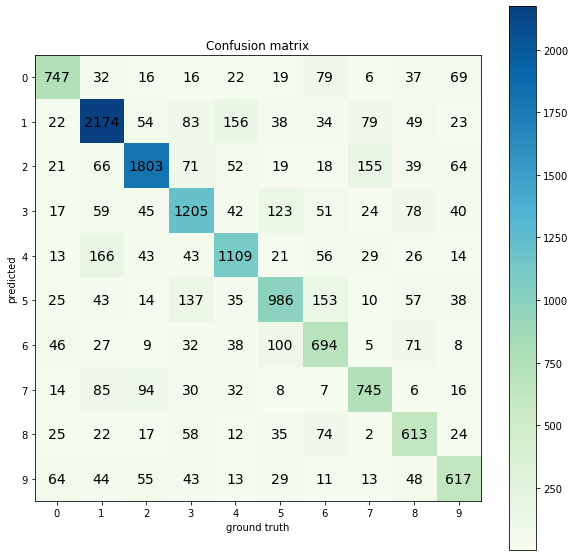

In [171]:
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
print (predictions, gt)
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

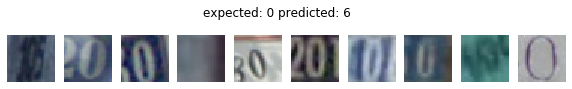

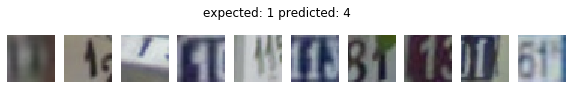

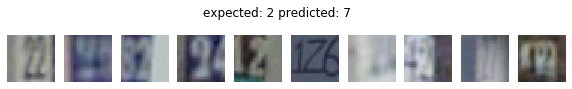

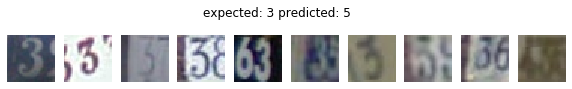

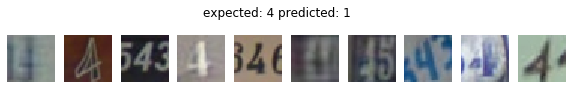

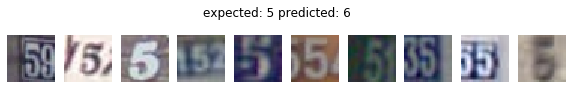

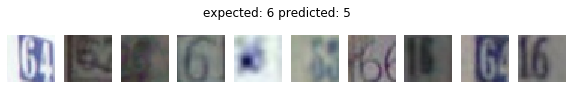

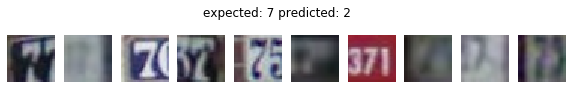

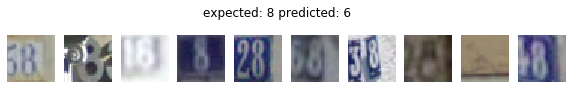

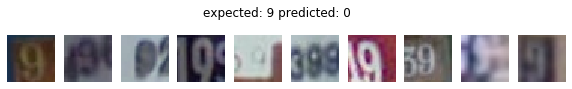

In [172]:
draw_confusions(predictions,gt)

In [173]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7065


Epoch:  0 lr:  [0.012]
Average loss: 1.642275, Train accuracy: 0.458417, Val accuracy: 0.640373
Epoch:  1 lr:  [0.006]
Average loss: 0.881629, Train accuracy: 0.730557, Val accuracy: 0.743562
Epoch:  2 lr:  [0.003]
Average loss: 0.688655, Train accuracy: 0.793246, Val accuracy: 0.786019
Epoch:  3 lr:  [0.0015]
Average loss: 0.584272, Train accuracy: 0.827100, Val accuracy: 0.815296
Epoch:  4 lr:  [0.00075]
Average loss: 0.516746, Train accuracy: 0.846944, Val accuracy: 0.833128


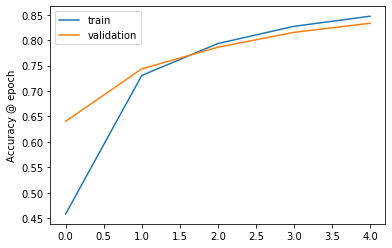

In [179]:
nn_model = nn.Sequential(
    Flattener(),
    nn.Linear(3*32*32, 1800),
    nn.ReLU(inplace=True),
    nn.Linear(1800,550),
    #nn.Dropout(p = 0.5, inplace = True),
    nn.BatchNorm1d(550),
    nn.Linear(550,10)
)
loss_history, train_history, val_history = train_model_with_learning_rate_decay2(
    model = nn_model,
    train_loader = train_loader, 
    val_loader = val_loader,
    loss = loss,
    num_epochs = 5,    
    learning_rate = 0.012,
    step_size = 1,
    gamma = 0.5
)

plot_history(loss_history, train_history, val_history)

In [180]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)


Test accuracy: 0.8218
